In [1]:
from data.loaders import load_reddit_data, load_btc_data
from preprocessing import RedditText, OHLCV
from utils import combine_ts
from modeling.model_selection import TimeCV, TradingSimulation, linear_importance, decision_importance
from modeling.stats import scores, pr_curve, roc_curve, confusion, causality
from modeling.postprocessing import aggregate_signals

/home/mario/github/reddit_btc/venv/lib/python3.8/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  from collections import Mapping


In [2]:
import matplotlib.pyplot as plt
from matplotlib.cm import gist_earth_r
from matplotlib.cm import seismic
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [4]:
ohlcv = OHLCV(load_btc_data())

In [5]:
return_threshold = 0.005
stop_time = "1h"
return_time = "1h"

In [6]:
ohlcv.add_labels(return_threshold, stop_time)

In [7]:
all_buzzwords = set(['short', 'sell', 'trade', 'invest', 'move', 'accumulate', 'moonn', 'pluto', 'mar', 'dump', 'rally', 'pnd', 'moonshot', 'spike', 'bearish', 'overbought', 'overextended', 'hopeful', 'optimistic', 'buy', 'liquidate', 'rebuy', 'hold', 'trade', 'hold', 'hodling', 'hodl', 'sell', 'buy', 'invest', 'liquidate', 'pump', 'whale', 'rally', 'pnd', 'bullish', 'overbought', 'oversold', 'euphoria', 'euphoric', 'bull', 'timing', 'squeeze', 'cycle', 'bullrun'])

In [8]:
try:
    all_tracked = pd.read_pickle("../data/cleantracked")
except:
    cleanreddit = RedditText("cleanreddit")
    all_tracked = cleanreddit.track(all_buzzwords)
    all_tracked.to_pickle("../data/cleantracked")

<AxesSubplot:xlabel='date'>

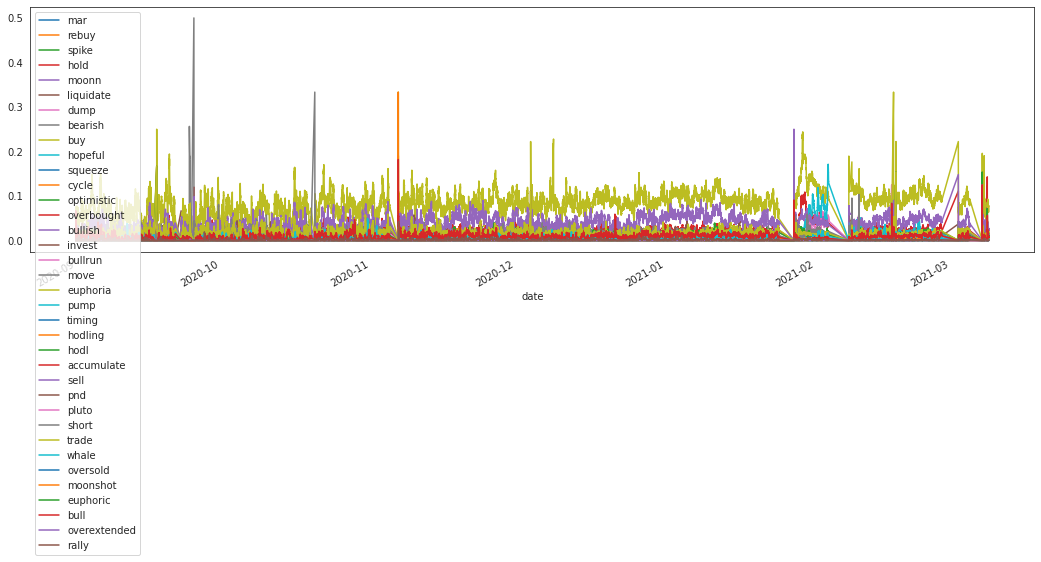

In [50]:
all_tracked_sma = all_tracked.rolling("4h").mean().dropna()
all_tracked_sma.sample(frac=0.1).plot(figsize=(18,5))

<AxesSubplot:xlabel='date'>

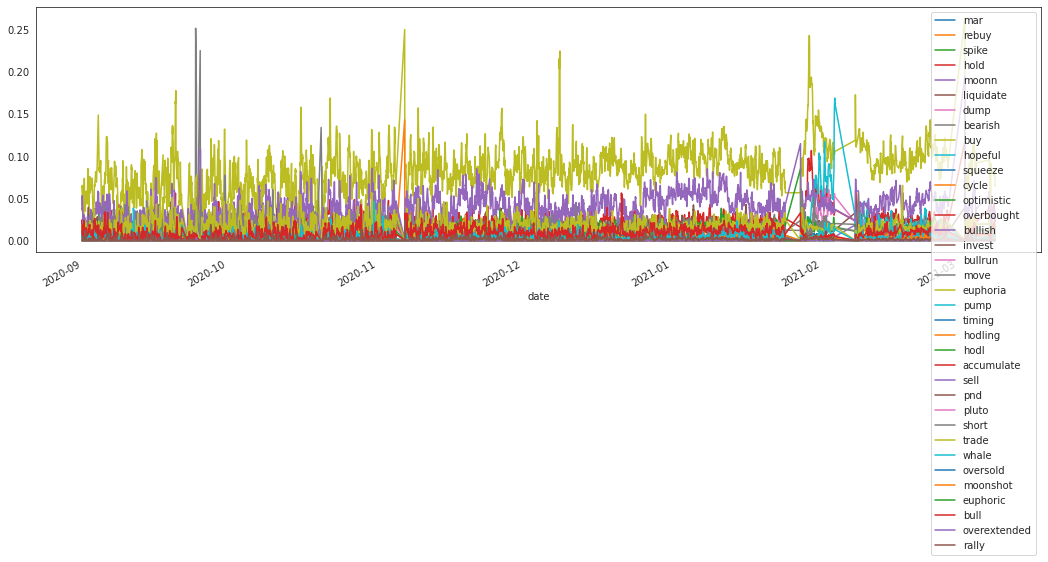

In [10]:
all_tracked_sma = all_tracked_sma.resample("5min").median().dropna()
all_tracked_sma.sample(frac=0.1).plot(figsize=(18,5))

In [11]:
end_date = "2021-01-27 00:00:00"

<AxesSubplot:xlabel='date'>

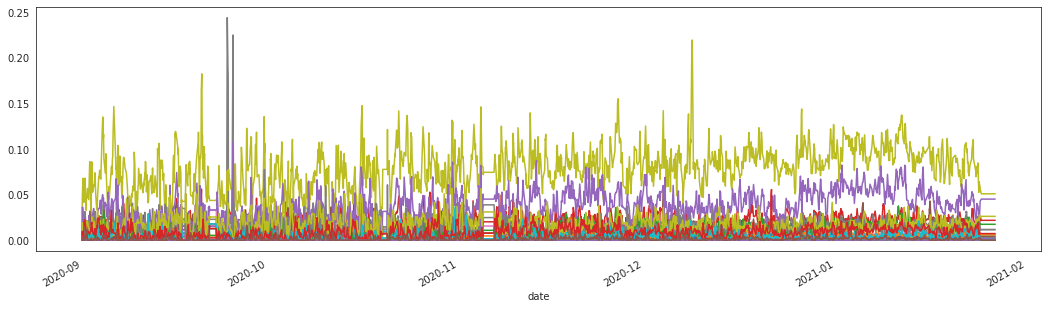

In [12]:
all_raw_data, label = combine_ts(ohlcv.data.label[:end_date], all_tracked_sma[:end_date])
all_raw_data.sample(frac=0.05).plot(figsize=(18,5), legend=False)

In [13]:
mask = all_raw_data.apply(lambda x: abs(stats.zscore(x)) > 1.5)
all_data = all_raw_data.mask(mask).interpolate().fillna(0)

<AxesSubplot:xlabel='date'>

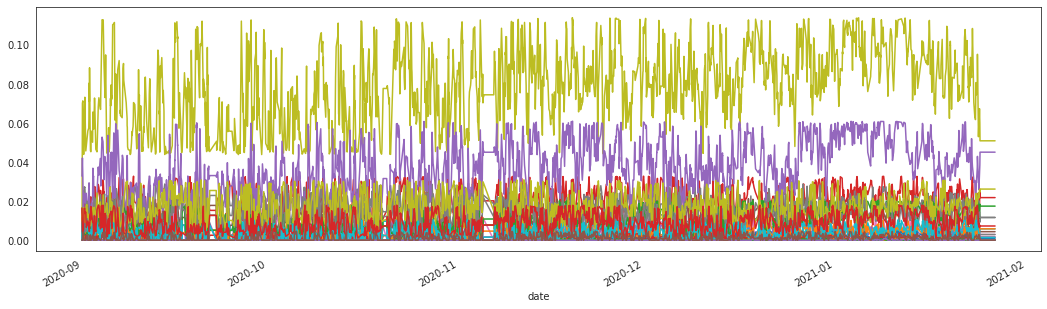

In [14]:
all_data.sample(frac=0.05).plot(figsize=(18,5), legend=False)

In [15]:
all_data = pd.DataFrame(MinMaxScaler().fit_transform(all_data), index=all_data.index, columns=all_data.columns)

In [40]:
all_data.index[]

SyntaxError: invalid syntax (<ipython-input-40-f9182e940009>, line 1)

[Text(0, 0.0, '2021-01-27'),
 Text(0, 10656.25, '2020-10-07'),
 Text(0, 21312.5, '2020-11-13'),
 Text(0, 31968.75, '2020-12-20'),
 Text(0, 42625.0, '2021-01-27')]

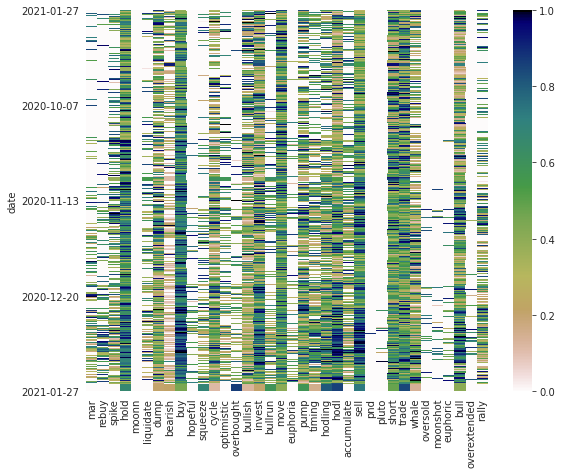

In [48]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(all_data, center=0.5, ax=ax, cmap=gist_earth_r)
ax.set_yticks(np.linspace(0, len(all_data), 5))
ax.set_yticklabels([all_data.index[int(i)-1].strftime('%Y-%m-%d') for i in np.linspace(0, len(all_data), 5)])

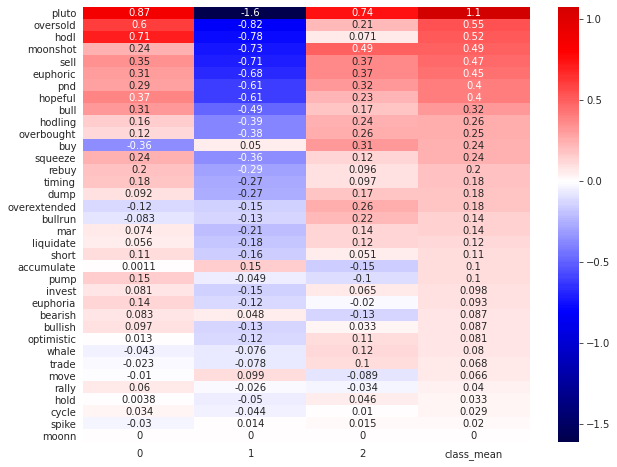

In [18]:
importance = linear_importance(all_data, label)

In [19]:
ohlcv.add_returns("1D")

In [20]:
#for buzzword in all_buzzwords:
#    _ = causality(all_data[buzzword], ohlcv.data.returns)

# Filter buzzwords

In [28]:
selected_buzzwords  = all_buzzwords
blacklist = []
for i in range(len(all_buzzwords)):
    importance = linear_importance(all_data[selected_buzzwords], label, plot=False)
    print(f"len blacklist: {len(blacklist)}", f"min importance: {importance.iloc[-1].class_mean}", f"dropped {importance.iloc[-1].name}")
    blacklist = blacklist + [importance.iloc[-1].name]
    selected_buzzwords  = [feature for feature in all_buzzwords if feature not in blacklist]
    if importance.iloc[-1].class_mean > 0.2:
        break  

len blacklist: 0 min importance: 0.0 dropped moonn
len blacklist: 1 min importance: 0.01982433285882337 dropped spike
len blacklist: 2 min importance: 0.028407870647577094 dropped cycle
len blacklist: 3 min importance: 0.03328027678663365 dropped hold
len blacklist: 4 min importance: 0.03907621251017541 dropped rally
len blacklist: 5 min importance: 0.06831557994979175 dropped move
len blacklist: 6 min importance: 0.06446234387232076 dropped trade
len blacklist: 7 min importance: 0.07548193891994885 dropped whale
len blacklist: 8 min importance: 0.07282449001752707 dropped bearish
len blacklist: 9 min importance: 0.08324333318034696 dropped optimistic
len blacklist: 10 min importance: 0.08466303289378045 dropped bullish
len blacklist: 11 min importance: 0.09483043724346966 dropped accumulate
len blacklist: 12 min importance: 0.09113968021686387 dropped invest
len blacklist: 13 min importance: 0.1017191533580324 dropped euphoria
len blacklist: 14 min importance: 0.10764648704524761 drop

In [29]:
selected_buzzwords

['rebuy',
 'buy',
 'hodl',
 'overbought',
 'bull',
 'pluto',
 'oversold',
 'squeeze',
 'moonshot',
 'euphoric',
 'sell',
 'hopeful',
 'hodling',
 'pnd']

In [30]:
selected_data = all_data[selected_buzzwords]

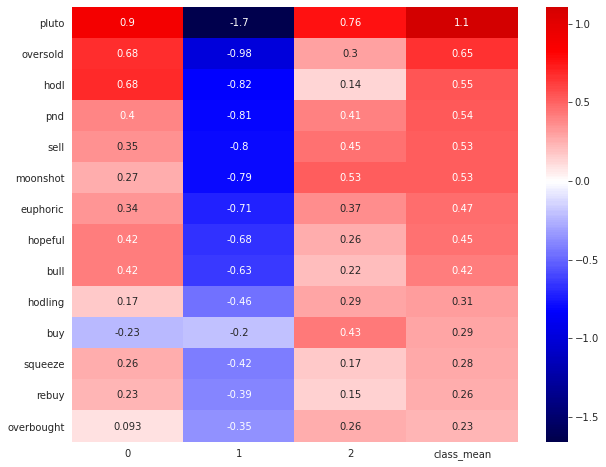

In [31]:
importance = linear_importance(selected_data, label)

In [32]:
model = LogisticRegression(class_weight="balanced", max_iter=500, solver="saga")

In [33]:
cv = TimeCV()
y_tests, y_preds, y_probs = cv.cross_validate(selected_data, label, model)

Fetched train fold before 2020-08-25 00:00:00 and after 2020-10-15 00:00:00
Fetched test fold from 2020-09-01 00:00:00 to 2020-10-07 23:55:00
Training on fold 1/4 | Have: 29952 samples
Predicting on fold 1/4 | Have: 10656 samples
----------------------------------------------------------------------------------------------------
Fetched train fold before 2020-10-01 00:00:00 and after 2020-11-21 00:00:00
Fetched test fold from 2020-10-08 00:00:00 to 2020-11-13 23:55:00
Training on fold 2/4 | Have: 27936 samples
Predicting on fold 2/4 | Have: 10656 samples
----------------------------------------------------------------------------------------------------
Fetched train fold before 2020-11-07 00:00:00 and after 2020-12-28 00:00:00
Fetched test fold from 2020-11-14 00:00:00 to 2020-12-20 23:55:00
Training on fold 3/4 | Have: 27936 samples
Predicting on fold 3/4 | Have: 10656 samples
----------------------------------------------------------------------------------------------------
Fetched

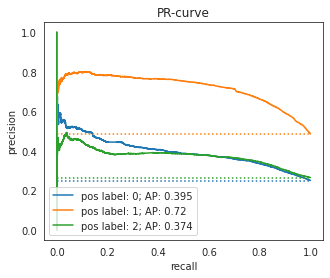

In [34]:
pr_curve(np.hstack(y_tests), np.hstack(y_preds), np.vstack(y_probs))

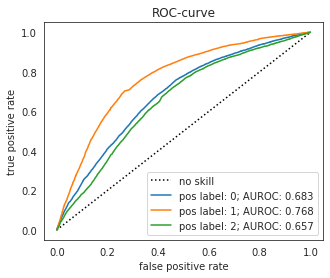

In [35]:
roc_curve(np.hstack(y_tests), np.hstack(y_preds), np.vstack(y_probs))

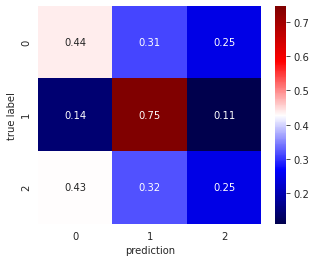

In [36]:
_ = confusion(np.hstack(y_tests), np.hstack(y_preds))

In [37]:
scores(np.hstack(y_tests), np.hstack(y_preds), np.vstack(y_probs)).T.head(2)

,0
matthews,0.260501
accuracy,0.537290


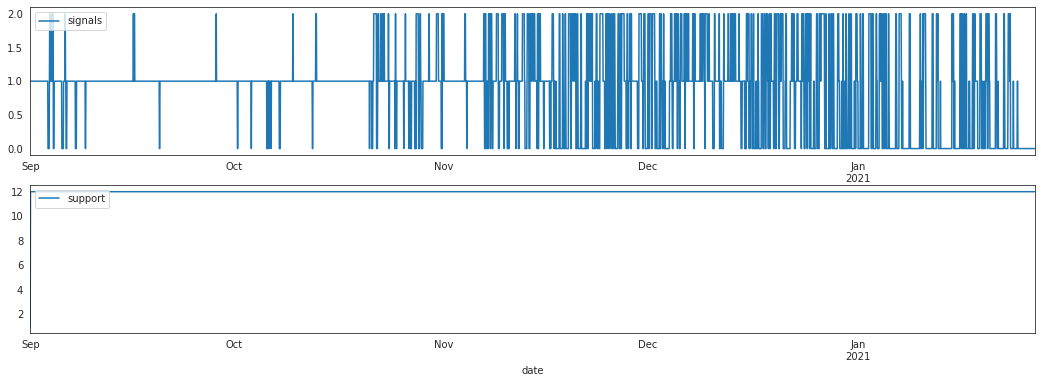

In [58]:
raw_signals = pd.Series(np.hstack(y_preds), index=selected_data.index)
signals, support = aggregate_signals(raw_signals, pace="1h")

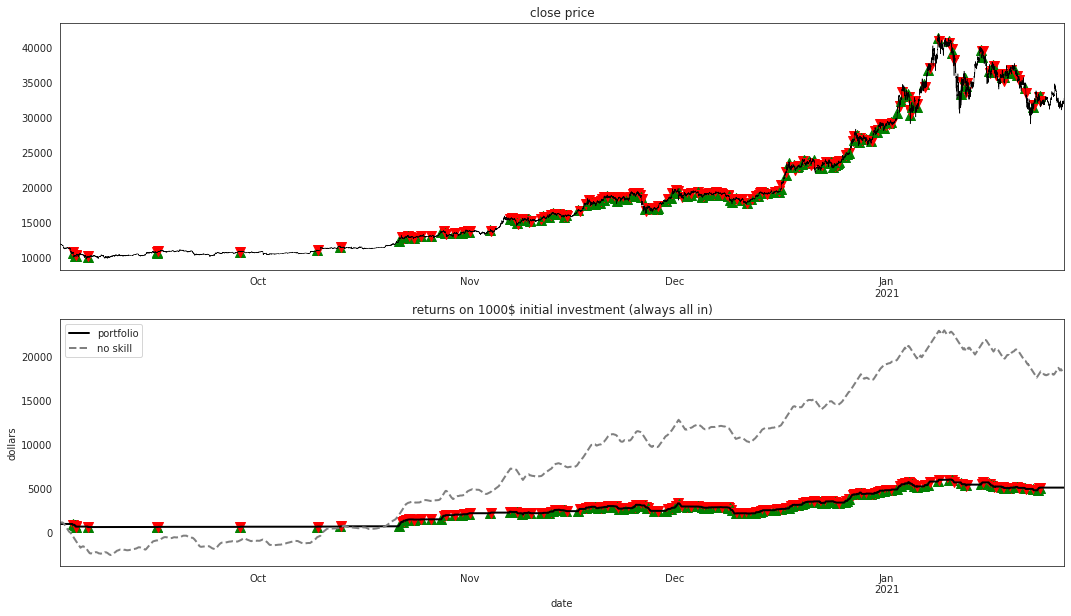

In [59]:
ts =  TradingSimulation(ohlcv.data)
portfolio = ts.simulate(signals)

In [60]:
portfolio

,portfolio,no_skill_portfolio
date,,
2020-09-02 00:00:00,1000.000000,1030.792500
2020-09-02 01:00:00,1000.000000,1058.559889
2020-09-02 02:00:00,1000.000000,1083.761958
2020-09-02 03:00:00,1000.000000,1108.873661
2020-09-02 04:00:00,1000.000000,1129.922969
...,...,...
2021-01-26 20:00:00,5123.098062,18208.889048
2021-01-26 21:00:00,5123.098062,18158.889048
2021-01-26 22:00:00,5123.098062,18108.889048
